# Exploring COVID-19 numbers: the data acquisition process

### Environment log:

(1) Using the "analytics3" anaconda environment; installing python packages directly through *pip* command.  
(2) Installed *pyvirtualenv*, *selenium*, and *[bs4](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#)* packages.  
(3) Installed *chromedriver* through "pip install chromedriver".  

(4) Got this error when initializing the Display function:
> display = Display(visible=0, size=(800,600))
> display.start()  
>> FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb': 'Xvfb'
>> EasyProcessError: start error EasyProcess cmd_param=['Xvfb', '-help'] cmd=['Xvfb', '-help'] oserror=[Errno 2] No such file or directory: 'Xvfb': 'Xvfb' return_code=None stdout="None" stderr="None" timeout_happened=False>

**Solution found in: https://bugs.debian.org/cgi-bin/bugreport.cgi?bug=860501**   
 
(5) Installed the system package xvfb through the shell line: *sudo apt-get install xvfb*.

- When running the "driver = webdriver.Chrome()" python command, I received the following error:  
> driver = webdriver.Chrome()
>> FileNotFoundError: [Errno 2] No such file or directory: 'chromedriver': 'chromedriver'  

(6) Even though, since I'm using conda environment I have set the chromedriver path before:  
> chromeDriverPath = '~/anaconda3/envs/anaytics3/'

The solution was to create a symbolic link in the path shown above, through the system bash, which made it work properly:  
> $ ln -s ~/anaconda3/envs/analytics3/chromedriver-Linux64 chromedriver  

(7) There are some broken links in the BMH oficial page: it misses the "https://portalarquivos.saude.gov.br/" portion of the link. We defined a function to address this issue.


## Epidemiological bulletins from World Health Organization - WHO
https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/  
https://github.com/danielsteman/COVID-19_WHO  
https://github.com/danielsteman/COVID-19_WHO/blob/master/WHO_webscrape.ipynb (the author uses PyPDF2)

## Epidemiological bulletins from Brazilian Ministry of Health
https://www.saude.gov.br/boletins-epidemiologicos
  - Coronavírus/COVID-19  
  - Dengue

## COVID-19 pandemic: official dashboard of the Ministry of Health of Brazil
https://covid.saude.gov.br/

### Initial statements

In [1]:
from pyvirtualdisplay import Display
from selenium import webdriver

## BeautifulSoup - BeautifulSoup is not needed at this time, since there's no parsing.
#from bs4 import 

In [2]:
# Definição de parâmetros
url = 'https://covid.saude.gov.br'
chromeDriverPath = '~/anaconda3/envs/analytics3/'
firefoxDriverPath = '~/anaconda3/envs/analytics3/'

### Web browsing

In this step of our data crawling we want to access the webpage through the Chromium driver. It is then appropriate to create some functions both for the page access as for its content analysis. However, it would be only possible if we know the page structure. In order to reach it, at this time we will try to read and explore it, trying to find the patterns and links we are looking for.

In [3]:
# Display starting:
display = Display(visible=0, size=(800,600))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '800x600x24', ':1021'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '800x600x24', ':1021'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [4]:
# Open the Chromium.driver for the intended page:
driver = webdriver.Chrome()

In [5]:
# Reading the page content and saving it specifying its encoding scheme:
driver.get(url)
page = driver.page_source.encode('utf-8')

### Initial exploration

In [6]:
# How large is the loaded page?
print(len(page))
# Data streaming type is expected:
print(type(page))

121907
<class 'bytes'>


In [7]:
## Showing only the first 2k positions of the bytes stream:
print(page[:2000])

b'<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" lang="en" class="plt-phablet plt-desktop md hydrated" mode="md"><head>\n    <meta charset="utf-8" /><style data-styles="">ion-select-popover,ion-select,ion-select-option,ion-menu-button,ion-menu,ion-menu-toggle,ion-action-sheet,ion-fab-button,ion-fab,ion-fab-list,ion-refresher-content,ion-refresher,ion-back-button,ion-backdrop,ion-alert,ion-loading,ion-toast,ion-card,ion-card-content,ion-card-header,ion-card-subtitle,ion-card-title,ion-item-option,ion-item-options,ion-item-sliding,ion-infinite-scroll-content,ion-infinite-scroll,ion-reorder,ion-reorder-group,ion-segment-button,ion-segment,ion-tab-button,ion-tab-bar,ion-chip,ion-modal,ion-popover,ion-searchbar,ion-app,ion-buttons,ion-content,ion-footer,ion-header,ion-router-outlet,ion-title,ion-toolbar,ion-route,ion-route-redirect,ion-router,ion-router-link,ion-avatar,ion-badge,ion-thumbnail,ion-col,ion-grid,ion-row,ion-nav,ion-nav-link,ion-slide,ion-slides,ion-checkbox,ion-img,

------------------

Once the website is loaded, **BeautifulSoup is typically used to mine its content and explore links of interest**. In this case, however, **the new portal made available by BMH was created in Firebase**. That is, there is no link to the database, but a response to the action of clicking the button.

Using Chrome's inspection tool, we can locate the element related to downloading the data and then emulate its click through the Selenium library.

In [8]:
## Path of the element from Chrome inspection tool:
xpathElement = '/html/body/app-root/ion-app/ion-router-outlet/app-home/ion-content/div[1]/div[2]/ion-button'

## Element corresponding to "Arquivo CSV" button:
dataDownloader = driver.find_element_by_xpath(xpathElement)

In [9]:
dataDownloader.click()

The steps above allowed us to download the CSV file to the default downloading directory. An open issue from this script is to set the specific file destiny. There are some references saying Selenium does not support dialogue boxes. Other references explore ways to do it out:

https://medium.com/@moungpeter/how-to-automate-downloading-files-using-python-selenium-and-headless-chrome-9014f0cdd196

---------------------

### Reading the downloaded CSV file:

In [10]:
import os
import glob

To figure out how to select the last downloaded file in a directory, I used the code available in https://stackoverflow.com/questions/39327032/how-to-get-the-latest-file-in-a-folder-using-python.

In [92]:
## Picking the last XLSX downloaded file:
list_of_files = glob.glob('/home/tbnsilveira/Downloads/*.xlsx') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

/home/tbnsilveira/Downloads/HIST_PAINEL_COVIDBR_21mai2020.xlsx


In [70]:
latest_file = list_of_files[2]
latest_file

'/home/tbnsilveira/Downloads/HIST_PAINEL_COVIDBR_20mai2020 (2).xlsx'

In [71]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [93]:
covidData = pd.read_excel(latest_file)

In [73]:
covidData

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,obitosAcumulado,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,0,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,0,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-03-01,10,210147125.0,2,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95911,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-16,20,3015268.0,4140,56,NaN,NaN
95912,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-17,21,3015268.0,4368,59,NaN,NaN
95913,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-18,21,3015268.0,4619,66,NaN,NaN
95914,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-19,21,3015268.0,4853,72,NaN,NaN


-----------------

In the way this script was initialy built, it was important to remove the CSV file after reading it, thus preventing the most current versions from being downloaded under another name. However, in the second week of May, the BMH changed the file format to XLSX, thus requiring to adapt the script. In this case, I choose to read the last downloaded file, then keeping all the copies in my system. In the case you don't want these copies, you can just uncomment the line below:

In [74]:
## In some situations you'll have to replace "~/" by the full local address (/home/user...)
#os.remove(latest_file)

------------------

## Visualizing some data:

In [75]:
covidData

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,obitosAcumulado,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125.0,1,0,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125.0,1,0,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125.0,1,0,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125.0,2,0,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-03-01,10,210147125.0,2,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95911,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-16,20,3015268.0,4140,56,NaN,NaN
95912,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-17,21,3015268.0,4368,59,NaN,NaN
95913,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-18,21,3015268.0,4619,66,NaN,NaN
95914,Centro-Oeste,DF,Brasília,53,530010.0,53001.0,Brasília,2020-05-19,21,3015268.0,4853,72,NaN,NaN


In [76]:
## Showing the line with the highest number of deaths:
idx = covidData.obitosAcumulado.idxmax()
covidData.iloc[idx]

regiao                        Brasil
estado                           NaN
municipio                        NaN
coduf                             76
codmun                           NaN
codRegiaoSaude                   NaN
nomeRegiaoSaude                  NaN
data                      2020-05-20
semanaEpi                         21
populacaoTCU2019         2.10147e+08
casosAcumulado                291579
obitosAcumulado                18859
Recuperadosnovos              116683
emAcompanhamentoNovos         156037
Name: 84, dtype: object

----------

#### Exploring only SC municipalities

In [77]:
covid_SC = covidData[covidData.estado == 'SC']

In [78]:
covid_SC.municipio.unique()

array([nan, 'Abelardo Luz', 'Agronômica', 'Água Doce', 'Águas de Chapecó',
       'Águas Mornas', 'Alto Bela Vista', 'Anchieta', 'Anita Garibaldi',
       'Antônio Carlos', 'Arabutã', 'Araquari', 'Araranguá', 'Armazém',
       'Arvoredo', 'Atalanta', 'Aurora', 'Balneário Arroio do Silva',
       'Balneário Camboriú', 'Balneário Barra do Sul',
       'Balneário Gaivota', 'Barra Velha', 'Benedito Novo', 'Biguaçu',
       'Blumenau', 'Bombinhas', 'Botuverá', 'Braço do Norte', 'Brusque',
       'Caçador', 'Camboriú', 'Campo Erê', 'Campos Novos', 'Canelinha',
       'Canoinhas', 'Capivari de Baixo', 'Catanduvas', 'Caxambu do Sul',
       'Chapecó', 'Cocal do Sul', 'Concórdia', 'Cordilheira Alta',
       'Coronel Freitas', 'Criciúma', 'Cunha Porã', 'Entre Rios',
       'Faxinal dos Guedes', 'Florianópolis', 'Forquilhinha', 'Fraiburgo',
       'Garopaba', 'Garuva', 'Gaspar', 'Governador Celso Ramos',
       'Grão Pará', 'Gravatal', 'Guabiruba', 'Guaramirim', 'Guatambú',
       "Herval d'Oeste

In [79]:
sns.set_style("whitegrid")

In [83]:
cidade = 'Florianópolis'

Text(0.5, 1.0, 'Número de casos COVID-19 acumulados em Florianópolis, SC, em 21/05/2020')

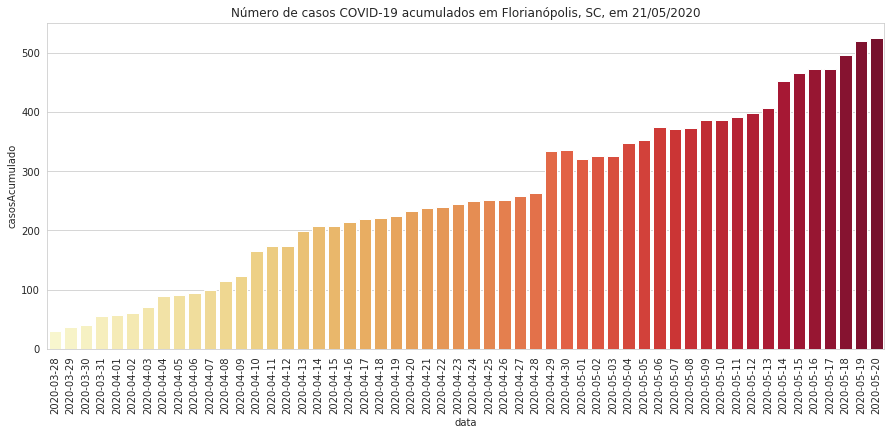

In [84]:
fig, ax = plt.subplots(figsize=(15,6))

ax = sns.barplot(x='data', y='casosAcumulado', data=covid_SC[covid_SC['municipio'] == cidade], palette='YlOrRd')
plt.xticks(rotation='vertical');
plt.title('Número de casos COVID-19 acumulados em {0}, SC, em 21/05/2020'.format(cidade))

In [85]:
covid_SC[covid_SC['municipio'] == 'Blumenau']

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,obitosAcumulado,Recuperadosnovos,emAcompanhamentoNovos
78789,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-03-28,13,357199.0,12,0,NaN,NaN
78790,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-03-29,14,357199.0,12,0,NaN,NaN
78791,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-03-30,14,357199.0,12,0,NaN,NaN
78792,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-03-31,14,357199.0,19,0,NaN,NaN
78793,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-04-01,14,357199.0,19,0,NaN,NaN
78794,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-04-02,14,357199.0,22,0,NaN,NaN
78795,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-04-03,14,357199.0,22,0,NaN,NaN
78796,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-04-04,14,357199.0,25,0,NaN,NaN
78797,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-04-05,15,357199.0,26,0,NaN,NaN
78798,Sul,SC,Blumenau,42,420240.0,42006.0,Médio Vale do Itajaí,2020-04-06,15,357199.0,26,0,NaN,NaN


----------------

## Visualizing the number of cases by state

#### Preparing the dataset only with tha state data:

In [94]:
## Getting the last date from data:
lastDay = covidData.data.max()
lastDay

'2020-05-21'

In [95]:
covidLastDay = covidData[covidData.data == lastDay]

In [96]:
covidLastDay = covidLastDay[(covidLastDay.estado.isna() == False) & 
                            (covidLastDay.municipio.isna() == True) &
                            (covidLastDay.populacaoTCU2019.isna() == False)]

covidLastDay = covidLastDay[['regiao','estado','data','populacaoTCU2019','casosAcumulado','obitosAcumulado']]

In [97]:
covidLastDay

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado
148,Norte,RO,2020-05-21,1777225.0,2659,101
212,Norte,AC,2020-05-21,881935.0,3103,78
280,Norte,AM,2020-05-21,4144597.0,25367,1620
341,Norte,RR,2020-05-21,605761.0,2146,72
405,Norte,PA,2020-05-21,8602865.0,19756,1852
468,Norte,AP,2020-05-21,845731.0,5188,151
532,Norte,TO,2020-05-21,1572866.0,1976,47
594,Nordeste,MA,2020-05-21,7075181.0,16058,663
657,Nordeste,PI,2020-05-21,3273227.0,2852,91
723,Nordeste,CE,2020-05-21,9132078.0,31413,2161


#### Normalizing data:

In [117]:
normalCovid = covidLastDay.copy()

In [119]:
## Contamination rate (pct of population)
normalCovid['contamRate'] = (normalCovid['casosAcumulado'] / normalCovid['populacaoTCU2019']) * 100
## Lethality rate (pct of cases)
normalCovid['lethality_pct'] = (normalCovid['obitosAcumulado'] / normalCovid['casosAcumulado']) * 100
## Death rate (pct of population)
normalCovid['deathRate'] = (normalCovid['obitosAcumulado'] / normalCovid['populacaoTCU2019']) * 100

In [120]:
normalCovid['casosAcumulado'].max()

73739

In [121]:
normalCovid['obitosAcumulado'].max()

5558

In [123]:
normalCovid.lethality_pct.idxmax()

1378

In [124]:
normalCovid.sort_values(by=['estado'])

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
212,Norte,AC,2020-05-21,881935.0,3103,78,0.351840,2.513696,0.008844
1003,Nordeste,AL,2020-05-21,3337357.0,4916,262,0.147302,5.329536,0.007851
280,Norte,AM,2020-05-21,4144597.0,25367,1620,0.612050,6.386250,0.039087
468,Norte,AP,2020-05-21,845731.0,5188,151,0.613434,2.910563,0.017854
1148,Nordeste,BA,2020-05-21,14873064.0,11941,376,0.080286,3.148815,0.002528
723,Nordeste,CE,2020-05-21,9132078.0,31413,2161,0.343985,6.879317,0.023664
1954,Centro-Oeste,DF,2020-05-21,3015268.0,5542,84,0.183798,1.515698,0.002786
1300,Sudeste,ES,2020-05-21,4018650.0,8878,363,0.220920,4.088759,0.009033
1878,Centro-Oeste,GO,2020-05-21,7018354.0,2114,85,0.030121,4.020814,0.001211
594,Nordeste,MA,2020-05-21,7075181.0,16058,663,0.226962,4.128783,0.009371


#### Dataframe queries:

In [125]:
normalCovid.query("estado=='AC'")

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
212,Norte,AC,2020-05-21,881935.0,3103,78,0.35184,2.513696,0.008844


In [126]:
normalCovid.query("obitosAcumulado > 1000")

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
280,Norte,AM,2020-05-21,4144597.0,25367,1620,0.612050,6.386250,0.039087
405,Norte,PA,2020-05-21,8602865.0,19756,1852,0.229644,9.374367,0.021528
723,Nordeste,CE,2020-05-21,9132078.0,31413,2161,0.343985,6.879317,0.023664
928,Nordeste,PE,2020-05-21,9557071.0,23911,1925,0.250192,8.050688,0.020142
1378,Sudeste,RJ,2020-05-21,17264943.0,32089,3412,0.185862,10.632927,0.019763
1464,Sudeste,SP,2020-05-21,45919049.0,73739,5558,0.160585,7.537395,0.012104


-----------------

### Four-Quadrant chart via Plotly:

In [270]:
import plotly.express as px
## List of colormaps available in: https://plotly.com/python/builtin-colorscales/

In [377]:
fig.update_traces(textposition='middle center',
                  textfont=dict(family="sans serif",
                                size=13))

fig.update_layout(
    ## Chart general set:
    height=520,
    width=980,
    plot_bgcolor='rgb(245,245,245)',
    title_text='Relação entre número de casos e letalidade da COVID-19 no Brasil, por estado - 2020.05.22',
    xaxis_title="<b>Letalidade (% óbitos/casos)</b>",
    yaxis_title="<b>Contaminação (% casos/população)</b>",
    hovermode=False,  #Disable the hover information.
    ## Axis ranges:
    xaxis=dict(
        autorange=False,
        range=[0, 12],
        type="linear"
    ),
    yaxis=dict(
        autorange=False,
        range=[0, 0.8],
        type="linear"),
    ## Adjusting the colorbar title:
    coloraxis=dict(
        colorbar=dict(
            title=dict(
                text='<b>Óbitos</b>'
            )
        )),
    ## Vertical and horizontal lines
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= 0, y1= 0.8,
          xref= 'x', x0= 6, x1= 6,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        dict(
          type= 'line',
          yref= 'y', y0= 0.4, y1= 0.4,
          xref= 'x', x0= 0, x1= 12,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                ))
        ],    
    ## Points annotations:
    annotations=[
        go.layout.Annotation(
            text='<b>Zona crítica</b>',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#E9967A',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta letalidade',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta contaminação',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Zona controlada',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
    ]
)

fig.show()

The command below shows all the figure parameters, in the case it is needed to change something.

In [368]:
print(fig)

Figure({
    'data': [{'hoverlabel': {'namelength': 0},
              'hovertemplate': ('<b>%{hovertext}</b><br><br>let' ... 'bitosAcumulado=%{marker.color}'),
              'hovertext': array(['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN', 'PB',
                                  'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC', 'RS', 'MS',
                                  'MT', 'GO', 'DF'], dtype=object),
              'legendgroup': '',
              'marker': {'color': array([ 101,   78, 1620,   72, 1852,  151,   47,  663,   91, 2161,  178,  245,
                                         1925,  262,   76,  376,  191,  363, 3412, 5558,  141,   98,  166,   17,
                                           34,   85,   84]),
                         'coloraxis': 'coloraxis',
                         'size': array([0.00568302, 0.00884419, 0.03908703, 0.01188588, 0.02152771, 0.01785438,
                                        0.00298818, 0.00937079, 0.00278013, 0